In [1]:
# -*- coding: utf-8 -*-
import dataiku
import pandas as pd, numpy as np
from dataiku import pandasutils as pdu

import matplotlib.pyplot as plt

# The data going into this step is defined in the follopwing Input View:
#
#  CREATE VIEW DATAIKU_ANALYTICS_SUB.DATA_SCIENCE.NAFCUSTOMER_REVENUE_AGGREGATED
#  AS
#  SELECT
#  CUSTOMER_ID,
#  CUSTOMER,
#  YEAR(REVENUE_DATE) as REVENUE_YEAR,
#  MONTH(REVENUE_DATE) as REVENUE_MONTH,
#  MIN(SETUP_DATE) AS SETUP_DATE,
#  MIN(BI_CUS_PAR) as BI_CUS_PAR,
#  MIN(BI_PRODUCT) as BI_PRODUCT,
#  MIN(BI_MRU) as BI_MRU,
#  SUM(REVENUE_AMOUNT_USD) as REVENUE_AMOUNT_USD,
#  SUM(GROSS_SPEND_AMOUNT) as GROSS_SPEND_AMOUNT,
#  SUM(PURCHASE_GALLONS_QTY) PURCHASE_GALLONS_QTY,
#  SUM(TOTAL_ACTIVE_CARD_COUNT) as TOTAL_ACTIVE_CARD_COUNT
#  FROM DATAIKU_ANALYTICS_SUB.DATA_SCIENCE.NAFCUSTOMER_REVENUE
#  WHERE (FUNDED_BY IS NULL OR FUNDED_BY='Unknown' OR FUNDED_BY='WEX Funded')
#  AND (NOT((REVENUE_CODE='26') AND (CUSTOMER_ID IS NULL)))
#  AND (NOT((REVENUE_CODE='E8') AND (CUSTOMER_ID IS NULL)))
#  GROUP BY 1,2,3,4


from datetime import date, datetime, timedelta
import time

t0 = time.time()

# Read recipe inputs
NAFCUSTOMER_REVENUE_AGGREGATED = dataiku.Dataset("NAFCUSTOMER_REVENUE_AGGREGATED")
NAFCUSTOMER_REVENUE_AGGREGATED_df = NAFCUSTOMER_REVENUE_AGGREGATED.get_dataframe()

t1 = time.time()
print("load duration", (t1-t0)/60.0, "minutes")

print(len(NAFCUSTOMER_REVENUE_AGGREGATED_df))
NAFCUSTOMER_REVENUE_AGGREGATED_df.head()

load duration 6.043561442693075 minutes
18075044


,CUSTOMER_ID,CUSTOMER,REVENUE_YEAR,REVENUE_MONTH,SETUP_DATE,BI_CUS_PAR,BI_PRODUCT,BI_MRU,REVENUE_AMOUNT_USD,GROSS_SPEND_AMOUNT,PURCHASE_GALLONS_QTY,TOTAL_ACTIVE_CARD_COUNT
0,77505014.0,ROLLINS INC,2021,9,2011-07-25 07:00:00+00:00,51000.0,10100.0,3100.0,83082.680000,3281713.55,1025688.994,11111.0
1,77616921.0,VAN HOY SONS CONTRACTING INC,2022,12,2013-05-16 07:00:00+00:00,11300.0,15308.0,4120.0,99.010000,2668.95,676.770,8.0
2,77097650.0,BRICKMAN GROUP,2023,1,2010-11-24 08:00:00+00:00,51000.0,10100.0,3100.0,0.000000,0.00,0.000,0.0
3,77040266.0,ALLMED EQUIPMENT SERVICES INC,2022,2,2011-11-15 08:00:00+00:00,11300.0,15100.0,4000.0,58.480000,2033.29,571.640,5.0
4,77490652.0,REGIONS SECURITY SERVICES INC,2019,11,2019-01-22 08:00:00+00:00,13000.0,15308.0,4000.0,787.751979,4632.04,1863.837,20.0


In [2]:
print(len(NAFCUSTOMER_REVENUE_AGGREGATED_df))
df = NAFCUSTOMER_REVENUE_AGGREGATED_df

18075044


In [3]:
# cast year as integer, create a revenue date column at the monthly grain
df['CUSTOMER_ID'] = df['CUSTOMER_ID'].astype('Int64')
df['SETUP_DATE_DT'] = pd.to_datetime(df['SETUP_DATE'])

df['REVENUE_YEAR'] = df['REVENUE_YEAR'].astype('Int64')
df['REVENUE_DATE'] = df['REVENUE_MONTH'].astype(str) + '-' + df['REVENUE_YEAR'].astype(str)
df['REVENUE_DATE'] = pd.to_datetime(df['REVENUE_DATE'], format='%m-%Y').dt.strftime('%m-%Y')

print(len(df))
df = df[df.REVENUE_YEAR!=2023]
print(len(df))

18075044
17673397


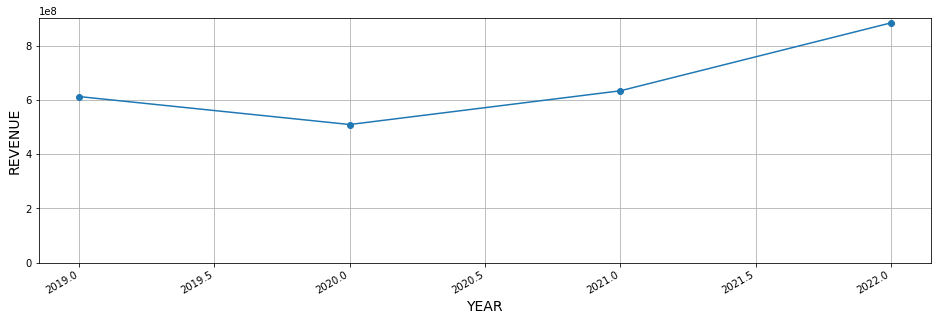

,REVENUE_YEAR,REVENUE_AMOUNT_USD
0,2019,6.118864e+08
1,2020,5.089365e+08
2,2021,6.331536e+08
3,2022,8.833015e+08


In [4]:
import matplotlib.dates as mdates

# aggregate revenue at annual grain
df_revenue_per_year = df.groupby(['REVENUE_YEAR']).REVENUE_AMOUNT_USD.sum().reset_index()

# plot out
fig, ax1 = plt.subplots(figsize=(16,5))
ax1.plot(df_revenue_per_year['REVENUE_YEAR'],df_revenue_per_year['REVENUE_AMOUNT_USD'], marker='o')
ax1.set_xlabel('YEAR', fontsize=14)
ax1.set_ylabel('REVENUE', fontsize=14)
ax1.grid()
ax1.set_ylim(ymin=0)
fig.autofmt_xdate()
#ax1.xaxis.set_major_locator(mdates.YearLocator())
plt.show()

df_revenue_per_year.head()

In [5]:
df_customer_monthly_card_count = df.groupby(['CUSTOMER_ID','REVENUE_DATE']).TOTAL_ACTIVE_CARD_COUNT.sum().reset_index()
df_customer_monthly_card_count.head()

,CUSTOMER_ID,REVENUE_DATE,TOTAL_ACTIVE_CARD_COUNT
0,77000000,01-2019,0.0
1,77000000,02-2019,0.0
2,77000000,03-2019,0.0
3,77000001,05-2022,1.0
4,77000001,06-2022,1.0


In [6]:
df_customer_max_monthly_card_sum = df.groupby(['CUSTOMER_ID']).TOTAL_ACTIVE_CARD_COUNT.max().reset_index()
df_customer_max_monthly_card_sum['CUSTOMER_FLEET_SIZE'] = 'NOT SET'
df_customer_max_monthly_card_sum.loc[df_customer_max_monthly_card_sum["TOTAL_ACTIVE_CARD_COUNT"]>1700,'CUSTOMER_FLEET_SIZE'] = "XL (>1700 Cards)"
df_customer_max_monthly_card_sum.loc[(df_customer_max_monthly_card_sum["TOTAL_ACTIVE_CARD_COUNT"]>115)&(df_customer_max_monthly_card_sum["TOTAL_ACTIVE_CARD_COUNT"]<=1700),'CUSTOMER_FLEET_SIZE'] = "L (>115 and <=1700 Cards)"
df_customer_max_monthly_card_sum.loc[(df_customer_max_monthly_card_sum["TOTAL_ACTIVE_CARD_COUNT"]>21)&(df_customer_max_monthly_card_sum["TOTAL_ACTIVE_CARD_COUNT"]<=115),'CUSTOMER_FLEET_SIZE'] = "M (>21 and <=115 Cards)"
df_customer_max_monthly_card_sum.loc[(df_customer_max_monthly_card_sum["TOTAL_ACTIVE_CARD_COUNT"]<=21),'CUSTOMER_FLEET_SIZE'] = "S (<=21 Cards)"
df_customer_max_monthly_card_sum.loc[(df_customer_max_monthly_card_sum["TOTAL_ACTIVE_CARD_COUNT"]==0),'CUSTOMER_FLEET_SIZE'] = "No Cards"
df_customer_max_monthly_card_sum.loc[df_customer_max_monthly_card_sum["TOTAL_ACTIVE_CARD_COUNT"].isnull(),'CUSTOMER_FLEET_SIZE'] = "No Cards"

df_customer_max_monthly_card_sum.CUSTOMER_FLEET_SIZE.value_counts(dropna=False)

S (<=21 Cards)               521977
No Cards                      80904
M (>21 and <=115 Cards)       40936
L (>115 and <=1700 Cards)      6735
XL (>1700 Cards)                334
Name: CUSTOMER_FLEET_SIZE, dtype: int64

In [7]:
df_customer_max_monthly_card_sum.head()

,CUSTOMER_ID,TOTAL_ACTIVE_CARD_COUNT,CUSTOMER_FLEET_SIZE
0,77000000,0.0,No Cards
1,77000001,2.0,S (<=21 Cards)
2,77000002,3.0,S (<=21 Cards)
3,77000003,21.0,S (<=21 Cards)
4,77000004,2.0,S (<=21 Cards)


In [8]:
# aggregate customers at min setup date
df_customer_min_setup = df.groupby(['CUSTOMER_ID']).SETUP_DATE.min().reset_index()
df_customer_min_setup.columns = ['CUSTOMER_ID','MIN_SETUP_DATE']
df_customer_min_setup['CUSTOMER_ID'] = df_customer_min_setup['CUSTOMER_ID'].astype('Int64')

df_customer_min_setup.head()

,CUSTOMER_ID,MIN_SETUP_DATE
0,77000000,2012-10-29 07:00:00+00:00
1,77000001,2022-04-12 07:00:00+00:00
2,77000002,2018-10-25 07:00:00+00:00
3,77000003,2022-06-08 07:00:00+00:00
4,77000004,2018-08-20 07:00:00+00:00


In [9]:
df_customer_min_setup.CUSTOMER_ID.value_counts(dropna=False)

77205570    1
77615114    1
77600771    1
77602820    1
77604869    1
           ..
77615094    1
77102832    1
77635564    1
77639658    1
NaN         0
Name: CUSTOMER_ID, Length: 650887, dtype: Int64

In [10]:
print(len(df))
df_j = pd.merge(df, df_customer_min_setup, on='CUSTOMER_ID', how='inner')
print(len(df_j))

df_j = pd.merge(df_j, df_customer_max_monthly_card_sum, on='CUSTOMER_ID', how='inner')
print(len(df_j))

df_j.head()

17673397
17673363
17673363


,CUSTOMER_ID,CUSTOMER,REVENUE_YEAR,REVENUE_MONTH,SETUP_DATE,BI_CUS_PAR,BI_PRODUCT,BI_MRU,REVENUE_AMOUNT_USD,GROSS_SPEND_AMOUNT,PURCHASE_GALLONS_QTY,TOTAL_ACTIVE_CARD_COUNT_x,SETUP_DATE_DT,REVENUE_DATE,MIN_SETUP_DATE,TOTAL_ACTIVE_CARD_COUNT_y,CUSTOMER_FLEET_SIZE
0,77505014,ROLLINS INC,2021,9,2011-07-25 07:00:00+00:00,51000.0,10100.0,3100.0,83082.68,3281713.55,1025688.994,11111.0,2011-07-25 07:00:00+00:00,09-2021,2011-07-25 07:00:00+00:00,13189.0,XL (>1700 Cards)
1,77505014,ROLLINS INC,2019,2,2011-07-25 07:00:00+00:00,11200.0,10100.0,3100.0,52556.80,1983897.65,846550.421,9855.0,2011-07-25 07:00:00+00:00,02-2019,2011-07-25 07:00:00+00:00,13189.0,XL (>1700 Cards)
2,77505014,ROLLINS INC,2022,10,2011-07-25 07:00:00+00:00,20800.0,10100.0,3100.0,107859.83,4528629.56,1165272.708,13111.0,2011-07-25 07:00:00+00:00,10-2022,2011-07-25 07:00:00+00:00,13189.0,XL (>1700 Cards)
3,77505014,ROLLINS INC,2022,2,2011-07-25 07:00:00+00:00,51000.0,10100.0,3100.0,81521.57,3253294.57,919689.648,11284.0,2011-07-25 07:00:00+00:00,02-2022,2011-07-25 07:00:00+00:00,13189.0,XL (>1700 Cards)
4,77505014,ROLLINS INC,2020,2,2011-07-25 07:00:00+00:00,11200.0,10100.0,3100.0,56223.23,2138943.47,862496.956,10371.0,2011-07-25 07:00:00+00:00,02-2020,2011-07-25 07:00:00+00:00,13189.0,XL (>1700 Cards)


In [11]:
print(len(df_j))
# retain only those customers that already existed before the analysis period
df_j = df_j[df_j.MIN_SETUP_DATE.dt.year<2019]
print(len(df_j))
df_j.head()

17673363
13581403


,CUSTOMER_ID,CUSTOMER,REVENUE_YEAR,REVENUE_MONTH,SETUP_DATE,BI_CUS_PAR,BI_PRODUCT,BI_MRU,REVENUE_AMOUNT_USD,GROSS_SPEND_AMOUNT,PURCHASE_GALLONS_QTY,TOTAL_ACTIVE_CARD_COUNT_x,SETUP_DATE_DT,REVENUE_DATE,MIN_SETUP_DATE,TOTAL_ACTIVE_CARD_COUNT_y,CUSTOMER_FLEET_SIZE
0,77505014,ROLLINS INC,2021,9,2011-07-25 07:00:00+00:00,51000.0,10100.0,3100.0,83082.68,3281713.55,1025688.994,11111.0,2011-07-25 07:00:00+00:00,09-2021,2011-07-25 07:00:00+00:00,13189.0,XL (>1700 Cards)
1,77505014,ROLLINS INC,2019,2,2011-07-25 07:00:00+00:00,11200.0,10100.0,3100.0,52556.80,1983897.65,846550.421,9855.0,2011-07-25 07:00:00+00:00,02-2019,2011-07-25 07:00:00+00:00,13189.0,XL (>1700 Cards)
2,77505014,ROLLINS INC,2022,10,2011-07-25 07:00:00+00:00,20800.0,10100.0,3100.0,107859.83,4528629.56,1165272.708,13111.0,2011-07-25 07:00:00+00:00,10-2022,2011-07-25 07:00:00+00:00,13189.0,XL (>1700 Cards)
3,77505014,ROLLINS INC,2022,2,2011-07-25 07:00:00+00:00,51000.0,10100.0,3100.0,81521.57,3253294.57,919689.648,11284.0,2011-07-25 07:00:00+00:00,02-2022,2011-07-25 07:00:00+00:00,13189.0,XL (>1700 Cards)
4,77505014,ROLLINS INC,2020,2,2011-07-25 07:00:00+00:00,11200.0,10100.0,3100.0,56223.23,2138943.47,862496.956,10371.0,2011-07-25 07:00:00+00:00,02-2020,2011-07-25 07:00:00+00:00,13189.0,XL (>1700 Cards)


In [125]:
# Fleet Sizes
# S (<=21 Cards)
# No Cards
# M (>21 and <=115 Cards)
# L (>115 and <=1700 Cards)
# XL (>1700 Cards)

print(len(df_j))
df_sub = df_j[df_j.CUSTOMER_FLEET_SIZE=='S (<=21 Cards)']
print(len(df_sub))

df_sub = df_sub.groupby(['REVENUE_YEAR']).CUSTOMER_ID.nunique().reset_index()
df_sub.columns = ['REVENUE_YEAR','CUSTOMER_COUNT']
df_sub.REVENUE_YEAR = df_sub.REVENUE_YEAR.astype(str)
df_sub.head()

max_y = df_sub.CUSTOMER_COUNT.max()
max_y = max_y + max_y*0.1

13581403
11261030


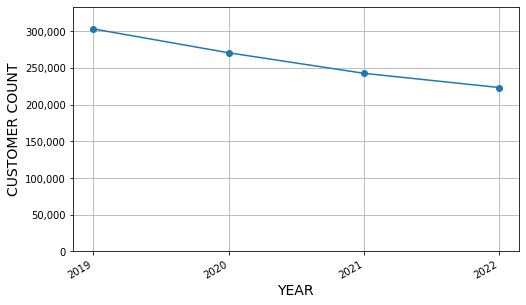

In [126]:
# plot out

from matplotlib.ticker import FormatStrFormatter,StrMethodFormatter,FuncFormatter

fig, ax1 = plt.subplots(figsize=(8,5))
ax1.plot(df_sub['REVENUE_YEAR'],df_sub['CUSTOMER_COUNT'], marker='o')
ax1.set_xlabel('YEAR', fontsize=14)
ax1.set_ylabel('CUSTOMER COUNT', fontsize=14)
ax1.grid()
ax1.set_ylim(ymin=0, ymax=max_y)
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
fig.autofmt_xdate()
#plt.text(0.94,224,"253")
plt.show()

In [128]:
df_sub.head()

,REVENUE_YEAR,CUSTOMER_COUNT
0,2019,303133
1,2020,270617
2,2021,242653
3,2022,223282


In [132]:
df_sub['PERCENT_SURVIVED'] = (df_sub.CUSTOMER_COUNT / df_sub.iloc[0].CUSTOMER_COUNT) * 100
df_sub.head()

,REVENUE_YEAR,CUSTOMER_COUNT,PERCENT_SURVIVED
0,2019,303133,100.000000
1,2020,270617,89.273355
2,2021,242653,80.048362
3,2022,223282,73.658097


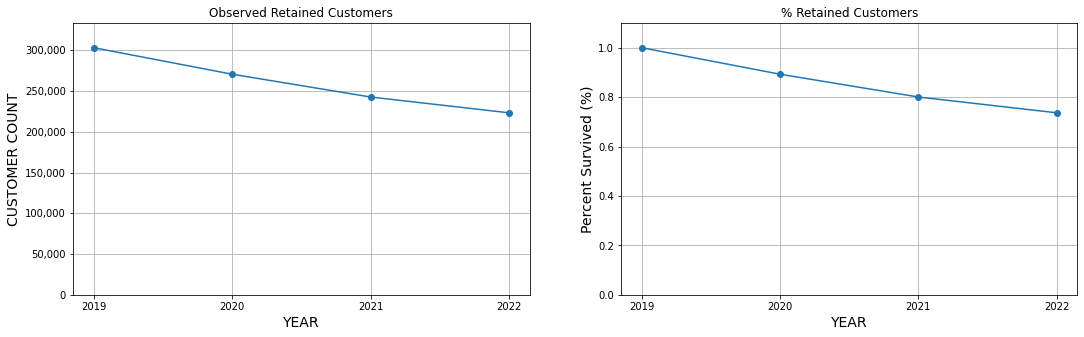

In [131]:
fig = plt.figure(figsize=(18,5))

ax1 = fig.add_subplot(1,2,1); 
plt.plot(df_sub['REVENUE_YEAR'],df_sub['CUSTOMER_COUNT'], marker='o')
ax1.set_ylim(ymin=0, ymax=max_y)
ax1.set_xlabel('YEAR', fontsize=14)
ax1.set_ylabel('CUSTOMER COUNT', fontsize=14)
ax1.grid()
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
plt.title('Observed Retained Customers')

ax2 = fig.add_subplot(1,2,2); 
plt.plot(df_sub['REVENUE_YEAR'],df_sub['PERCENT_SURVIVED'], marker='o')
ax2.set_ylim(ymin=0, ymax=1.1)
ax2.set_xlabel('YEAR', fontsize=14)
ax2.set_ylabel('Percent Survived (%)', fontsize=14)
ax2.grid()
#ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
plt.title('% Retained Customers')

plt.show()

In [0]:
# Compute recipe outputs from inputs
# TODO: Replace this part by your actual code that computes the output, as a Pandas dataframe
# NB: DSS also supports other kinds of APIs for reading and writing data. Please see doc.

#TENURE_CALC_df = NAFCUSTOMER_REVENUE_AGGREGATED_df # For this sample code, simply copy input to output


# Write recipe outputs
#TENURE_CALC = dataiku.Dataset("TENURE_CALC")
#TENURE_CALC.write_with_schema(TENURE_CALC_df)